# Telecom Customer Churn Prediction (with Feast and XGBoost)

This tutorial will demonstrate the use of Feast in productionising a churn model. The tutorial is broken down into two sections

1. Churn Modelling (without Feast): In this section we explore the data, refine it, train a model, and evaluate its performance.
2. Churn Modelling (with Feast): In this section we introduce Feast for feature storage, management, as well as serving.


This tutorial is an extension of [this](https://www.kaggle.com/pavanraj159/telecom-customer-churn-prediction/comments#6.-Model-Performances) Kaggle notebook

## 1. Churn Modelling (without Feast)

In [516]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import  Image
%matplotlib inline
import pandas as pd
import seaborn as sns
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import statsmodels, yellowbrick
import sklearn # Tested with 0.22.1
import imblearn
from slugify import slugify

### 1.1 Data

In [517]:
telcom = pd.read_csv(r"telco_customer_churn.csv")
telcom.head()

,customer_id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 1.2 Data Manipulation

In [518]:
# Replacing spaces with null values in total charges column
telcom['TotalCharges'] = telcom["TotalCharges"].replace(" ",np.nan)

# Dropping null values from total charges column which contain .15% missing data 
telcom = telcom[telcom["TotalCharges"].notnull()]
telcom = telcom.reset_index()[telcom.columns]

# Convert to float type
telcom["TotalCharges"] = telcom["TotalCharges"].astype(float)

# Replace 'No internet service' to No for the following columns
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']
for i in replace_cols : 
    telcom[i]  = telcom[i].replace({'No internet service' : 'No'})
    
# Replace binary values with strings
telcom["SeniorCitizen"] = telcom["SeniorCitizen"].replace({1:"Yes",0:"No"})

# Tenure to categorical column
def tenure_lab(telcom) :
    
    if telcom["tenure"] <= 12 :
        return "Tenure_0-12"
    elif (telcom["tenure"] > 12) & (telcom["tenure"] <= 24 ):
        return "Tenure_12-24"
    elif (telcom["tenure"] > 24) & (telcom["tenure"] <= 48) :
        return "Tenure_24-48"
    elif (telcom["tenure"] > 48) & (telcom["tenure"] <= 60) :
        return "Tenure_48-60"
    elif telcom["tenure"] > 60 :
        return "Tenure_gt_60"
telcom["tenure_group"] = telcom.apply(lambda telcom:tenure_lab(telcom),
                                      axis = 1)

# Separating churn and non churn customers
churn     = telcom[telcom["Churn"] == "Yes"]
not_churn = telcom[telcom["Churn"] == "No"]

# Separating catagorical and numerical columns
Id_col     = ['customerID']
target_col = ["Churn"]
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]


### 1.3 Data Processing

In [519]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Customer id col
Id_col     = ['customer_id']

# Target columns
target_col = ["churn"]

# Categorical columns
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]

# Numerical columns
num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]

# Binary columns with 2 values
bin_cols   = telcom.nunique()[telcom.nunique() == 2].keys().tolist()

# Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

# Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    telcom[i] = le.fit_transform(telcom[i])
    
# Duplicating columns for multi value columns
telcom = pd.get_dummies(data = telcom,columns = multi_cols )

# Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(telcom[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

# Dropping original values merging scaled values for numerical columns
df_telcom_og = telcom.copy()
telcom = telcom.drop(columns = num_cols,axis = 1)
telcom = telcom.merge(scaled,left_index=True,right_index=True,how = "left")

# Clean up column names
telcom.columns = [slugify(col, lowercase=True, separator='_') for col in telcom.columns]
telcom.head()

,customer_id,gender,seniorcitizen,partner,dependents,phoneservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,...,paymentmethod_electronic_check,paymentmethod_mailed_check,tenure_group_tenure_0_12,tenure_group_tenure_12_24,tenure_group_tenure_24_48,tenure_group_tenure_48_60,tenure_group_tenure_gt_60,tenure,monthlycharges,totalcharges
0,7590-VHVEG,0,0,1,0,0,0,1,0,0,...,1,0,1,0,0,0,0,-1.280248,-1.161694,-0.994194
1,5575-GNVDE,1,0,0,0,1,1,0,1,0,...,0,1,0,0,1,0,0,0.064303,-0.260878,-0.173740
2,3668-QPYBK,1,0,0,0,1,1,1,0,0,...,0,1,1,0,0,0,0,-1.239504,-0.363923,-0.959649
3,7795-CFOCW,1,0,0,0,0,1,0,1,1,...,0,0,0,0,1,0,0,0.512486,-0.747850,-0.195248
4,9237-HQITU,0,0,0,0,1,0,0,0,0,...,1,0,1,0,0,0,0,-1.239504,0.196178,-0.940457


### 1.4 Descriptive Statistics

In [522]:
telcom.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,7032,7032,0641-EVBOJ,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7032,NaN,NaN,NaN,0.504693,0.500014,0,0,1,1,1
seniorcitizen,7032,NaN,NaN,NaN,0.1624,0.368844,0,0,0,0,1
partner,7032,NaN,NaN,NaN,0.482509,0.499729,0,0,0,1,1
dependents,7032,NaN,NaN,NaN,0.298493,0.457629,0,0,0,1,1
phoneservice,7032,NaN,NaN,NaN,0.903299,0.295571,0,1,1,1,1
onlinesecurity,7032,NaN,NaN,NaN,0.286547,0.45218,0,0,0,1,1
onlinebackup,7032,NaN,NaN,NaN,0.344852,0.475354,0,0,0,1,1
deviceprotection,7032,NaN,NaN,NaN,0.343857,0.475028,0,0,0,1,1
techsupport,7032,NaN,NaN,NaN,0.290102,0.453842,0,0,0,1,1


### 1.5 Correlation Matrix

In [523]:
correlation = telcom.corr()
matrix_cols = correlation.columns.tolist()
corr_array = np.array(correlation)
trace = go.Heatmap(z=corr_array,
                   x=matrix_cols,
                   y=matrix_cols,
                   colorscale="Viridis",
                   colorbar=dict(title="Pearson Correlation coefficient",
                                 titleside="right"
                                 ),
                   )
layout = go.Layout(dict(title="Correlation Matrix for variables",
                        autosize=False,
                        height=720,
                        width=800,
                        margin=dict(r=0, l=210,
                                    t=25, b=210,
                                    ),
                        yaxis=dict(tickfont=dict(size=9)),
                        xaxis=dict(tickfont=dict(size=9))
                        )
                   )
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)


### 1.6 Data Preparation for Training

In [524]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import precision_score,recall_score
from yellowbrick.classifier import DiscriminationThreshold

# Split into a train and test set
train, test = train_test_split(telcom,test_size = .25 ,random_state = 111)
    
# Seperating dependent and independent variables
cols    = [i for i in telcom.columns if i not in Id_col + target_col]
training_x = train[cols]
training_y = train[target_col]
testing_x  = test[cols]
testing_y  = test[target_col]

### 1.7 Training

In [525]:
from xgboost import XGBClassifier

model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                      colsample_bytree=1, gamma=0, learning_rate=0.9, max_delta_step=0,
                      max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
                      n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
                      reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                      silent=True, subsample=1)

# Train model
model.fit(training_x, training_y)
predictions = model.predict(testing_x)
probabilities = model.predict_proba(testing_x)

### 1.8 Analysis

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.9, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=1, nthread=1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
              subsample=1, tree_method=None, validate_parameters=False,
              verbosity=None)

 Classification report : 
               precision    recall  f1-score   support

           0       0.81      0.86      0.83      1268
           1       0.56      0.47      0.51       490

    accuracy                           0.75      1758
   macro avg       0.69      0.67      0.67      1758
weighted avg       0.74      0.75 

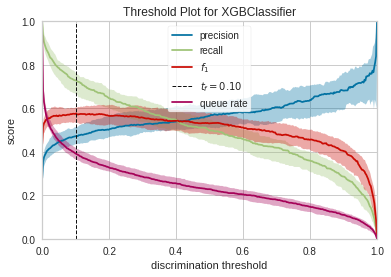

In [526]:
coefficients = pd.DataFrame(model.feature_importances_)
column_df = pd.DataFrame(cols)
coef_sumry = (pd.merge(coefficients, column_df, left_index=True,
                       right_index=True, how="left"))
coef_sumry.columns = ["coefficients", "features"]
coef_sumry = coef_sumry.sort_values(by="coefficients", ascending=False)

print(model)
print("\n Classification report : \n", classification_report(testing_y, predictions))
print("Accuracy   Score : ", accuracy_score(testing_y, predictions))
# confusion matrix
conf_matrix = confusion_matrix(testing_y, predictions)
# roc_auc_score
model_roc_auc = roc_auc_score(testing_y, predictions)
print("Area under curve : ", model_roc_auc, "\n")
fpr, tpr, thresholds = roc_curve(testing_y, probabilities[:, 1])

# plot confusion matrix
trace1 = go.Heatmap(z=conf_matrix,
                    x=["Not churn", "Churn"],
                    y=["Not churn", "Churn"],
                    showscale=False, colorscale="Picnic",
                    name="matrix")

# plot roc curve
trace2 = go.Scatter(x=fpr, y=tpr,
                    name="Roc : " + str(model_roc_auc),
                    line=dict(color=('rgb(22, 96, 167)'), width=2))
trace3 = go.Scatter(x=[0, 1], y=[0, 1],
                    line=dict(color=('rgb(205, 12, 24)'), width=2,
                              dash='dot'))

# plot coeffs
trace4 = go.Bar(x=coef_sumry["features"], y=coef_sumry["coefficients"],
                name="coefficients",
                marker=dict(color=coef_sumry["coefficients"],
                            colorscale="Picnic",
                            line=dict(width=.6, color="black")))

# subplots
fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                        subplot_titles=('Confusion Matrix',
                                        'Receiver operating characteristic',
                                        'Feature Importances'))

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 2)
fig.append_trace(trace4, 2, 1)

fig['layout'].update(showlegend=False, title="Model performance",
                     autosize=False, height=900, width=800,
                     plot_bgcolor='rgba(240,240,240, 0.95)',
                     paper_bgcolor='rgba(240,240,240, 0.95)',
                     margin=dict(b=195))
fig["layout"]["xaxis2"].update(dict(title="false positive rate"))
fig["layout"]["yaxis2"].update(dict(title="true positive rate"))
fig["layout"]["xaxis3"].update(dict(showgrid=True, tickfont=dict(size=10),
                                    tickangle=90))
py.iplot(fig)

visualizer = DiscriminationThreshold(model)
visualizer.fit(training_x, training_y)
visualizer.poof()

## 2. Churn Modelling (with Feast)

1. Make sure your features are registered with Feast and that data is being published to stores
2. Train your model
3. Serve your model

### 2.1 Configure Feast

In [540]:
os.environ['FEAST_CORE_URL'] = 'localhost:6565'
os.environ['FEAST_ONLINE_URL'] = 'localhost:6566'
os.environ['FEAST_BATCH_URL'] = 'localhost:6567'
os.environ['FEAST_PROJECT'] = 'default'

In [527]:
from feast import Client, FeatureSet, Entity, ValueType

In [528]:
client = Client(core_url=os.environ['FEAST_CORE_URL'])
client.set_project(os.environ['FEAST_PROJECT'])

### 2.2 Create a Feature Set

In [529]:
customer_churn_fs = FeatureSet('customer_churn')

In [530]:
# Add a datetime column to todays date
telcom['datetime'] = pd.Series([dt.datetime.now()] * len(entity_df))

In [278]:
customer_churn_fs.infer_fields_from_df(telcom, entities=[Entity(name='customer_id', dtype=ValueType.STRING)])

Entity customer_id(ValueType.STRING) manually updated (replacing an existing field).
Feature gender (ValueType.INT64) added from dataframe.
Feature seniorcitizen (ValueType.INT64) added from dataframe.
Feature partner (ValueType.INT64) added from dataframe.
Feature dependents (ValueType.INT64) added from dataframe.
Feature phoneservice (ValueType.INT64) added from dataframe.
Feature onlinesecurity (ValueType.INT64) added from dataframe.
Feature onlinebackup (ValueType.INT64) added from dataframe.
Feature deviceprotection (ValueType.INT64) added from dataframe.
Feature techsupport (ValueType.INT64) added from dataframe.
Feature streamingtv (ValueType.INT64) added from dataframe.
Feature streamingmovies (ValueType.INT64) added from dataframe.
Feature paperlessbilling (ValueType.INT64) added from dataframe.
Feature churn (ValueType.INT64) added from dataframe.
Feature multiplelines_no (ValueType.INT64) added from dataframe.
Feature multiplelines_no_phone_service (ValueType.INT64) added fr

In [281]:
client.apply(customer_churn_fs)

Feature set updated/created: "customer_churn:1"


In [285]:
customer_churn_fs = client.get_feature_set('customer_churn')
print(client.get_feature_set('customer_churn'))

{
  "spec": {
    "name": "customer_churn",
    "version": 1,
    "entities": [
      {
        "name": "customer_id",
        "valueType": "STRING"
      }
    ],
    "features": [
      {
        "name": "churn",
        "valueType": "INT64"
      },
      {
        "name": "seniorcitizen",
        "valueType": "INT64"
      },
      {
        "name": "contract_month_to_month",
        "valueType": "INT64"
      },
      {
        "name": "streamingmovies",
        "valueType": "INT64"
      },
      {
        "name": "dependents",
        "valueType": "INT64"
      },
      {
        "name": "paymentmethod_credit_card_automatic",
        "valueType": "INT64"
      },
      {
        "name": "multiplelines_no_phone_service",
        "valueType": "INT64"
      },
      {
        "name": "techsupport",
        "valueType": "INT64"
      },
      {
        "name": "internetservice_no",
        "valueType": "INT64"
      },
      {
        "name": "tenure_group_tenure_gt_60",
        "va

### 2.3 Load Features Into Feast

In [286]:
client.ingest(customer_churn_fs, telcom)

  0%|          | 0/7032 [00:00<?, ?rows/s]

Waiting for feature set to be ready for ingestion...


100%|██████████| 7032/7032 [00:02<00:00, 2771.19rows/s]

Ingestion complete!

Ingestion statistics:
Success: 7032/7032
Removing temporary file(s)...


### 2.4 (Optional) Create a Model Class

In [537]:
import joblib
import os

from feast import Client
from feast.serving.ServingService_pb2 import GetOnlineFeaturesRequest
from feast.types.Value_pb2 import Value
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from pandas import DataFrame


class ChurnModel:
    def __init__(self, features, target, model_path=None):
        # Set up Feast clients to retrieve training and online serving data
        self._feast_online_client = Client(serving_url=os.environ['FEAST_ONLINE_URL'])
        self._feast_batch_client = Client(serving_url=os.environ['FEAST_BATCH_URL'],
                                          core_url=os.environ['FEAST_CORE_URL'])
        self._feast_project = os.environ['FEAST_PROJECT']

        # Path to either save models after training or load models for serving
        self._model = None
        self._model_path = model_path
        self._features = features
        self._target = target

    def train(self, entity_df):
        # Initialize a new XGBoost model
        self._model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                                    colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
                                    max_depth=7, min_child_weight=1, missing=None, n_estimators=50,
                                    n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
                                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                                    silent=True, subsample=1)

        # Get training dataset from Feast
        train_x, test_x, train_y, test_y = self._get_training_data(entity_df)

        # Train model
        self._model.fit(train_x, train_y, early_stopping_rounds=40, eval_set=[(test_x, test_y)])

    def _get_training_data(self, entity_df):
        # Add the target variable to our feature list
        features = self._features + [self._target]

        # Retrieve training dataset from Feast
        dataset = self._feast_batch_client.get_batch_features(
            feature_refs=features,
            entity_rows=entity_df,
            default_project=self._feast_project).to_dataframe()

        # Split into a train and test set
        return train_test_split(dataset[self._features], dataset[self._target],
                                test_size=0.25, random_state=111)

    def predict(self, customer_ids):
        # Load external model if no model exists
        if not self._model:
            self._model = joblib.load(self._model_path)

        # Get online features from Feast for the list of customers
        prediction = self._model.predict(data=self._get_online_features(customer_ids))

        # Return churn predictions
        return prediction

    def _get_online_features(self, customer_ids):
        # Build request out of entities (customer ids)
        entity_rows = []
        for customer_id in customer_ids:
            entity_rows.append(
                GetOnlineFeaturesRequest.EntityRow(fields={'customer_id': Value(string_val=customer_id)})
            )

        # Retrieve online features from Feast for given entities
        data = self._feast_online_client.get_online_features(feature_refs=self._features,
                                                             entity_rows=entity_rows,
                                                             default_project=self._feast_project)
        # Convert to Pandas dataframe
        features_dict = dict.fromkeys(self._features)
        for row in data.field_values:
            for feature in features_dict.keys():
                if features_dict[feature] is None:
                    features_dict[feature] = []
                features_dict[feature].append(row.fields[self._feast_project + '/' + feature].int64_val)
        return DataFrame.from_dict(features_dict)

    def save_model(self, model_path=None):
        # Export trained model to local path### 2.2 Create a Feature Set
        if not model_path:
            model_path = self._model_path
        joblib.dump(self._model, model_path)

### 2.5 Define Features and Target

In [534]:
features = [
 'gender',
 'seniorcitizen',
 'partner',
 'dependents',
 'phoneservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotecti### 2.4 (Optional) Create a Model Classon',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'paperlessbilling',
 'multiplelines_no',
 'multiplelines_no_phone_service',
 'multiplelines_yes',
 'internetservice_dsl',
 'internetservice_fiber_optic',
 'internetservice_no',
 'contract_month_to_month',
 'contract_one_year',
 'contract_two_year',
 'paymentmethod_bank_transfer_automatic',
 'paymentmethod_credit_card_automatic',
 'paymentmethod_electronic_check',
 'paymentmethod_mailed_check',
 'tenure_group_tenure_0_12',
 'tenure_group_tenure_12_24',
 'tenure_group_tenure_24_48',
 'tenure_group_tenure_48_60',
 'tenure_group_tenure_gt_60',
 'tenure',
 'monthlycharges',
 'totalcharges']

target = 'churn'

In [459]:
cm = ChurnModel(features=features, target=target)

### 2.6 Train Model

In [460]:
cm.train(entity_df)

[0]	validation_0-error:0.22071
Will train until validation_0-error hasn't improved in 40 rounds.
[1]	validation_0-error:0.21900
[2]	validation_0-error:0.21786
[3]	validation_0-error:0.22071
[4]	validation_0-error:0.21388
[5]	validation_0-error:0.21388
[6]	validation_0-error:0.21786
[7]	validation_0-error:0.21445
[8]	validation_0-error:0.21388
[9]	validation_0-error:0.20990
[10]	validation_0-error:0.21160
[11]	validation_0-error:0.20819
[12]	validation_0-error:0.21160
[13]	validation_0-error:0.21104
[14]	validation_0-error:0.21274
[15]	validation_0-error:0.21104
[16]	validation_0-error:0.20933
[17]	validation_0-error:0.20990
[18]	validation_0-error:0.21104
[19]	validation_0-error:0.20990
[20]	validation_0-error:0.20649
[21]	validation_0-error:0.20649
[22]	validation_0-error:0.20535
[23]	validation_0-error:0.20421
[24]	validation_0-error:0.20592
[25]	validation_0-error:0.20762
[26]	validation_0-error:0.20649
[27]	validation_0-error:0.20933
[28]	validation_0-error:0.20876
[29]	validation_

### 2.7 Predict

In [503]:
churn_prediction = cm.predict(['9237-HQITU', '9305-CDSKC', '7892-POOKP', '4190-MFLUW', '6467-CHFZW', '8665-UTDHZ'])

In [504]:
print(churn_prediction)

[0 0 1 0 1 0]
